In [19]:
import pandas as pd
import numpy as np
from datetime import datetime
import openpyxl

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Q3
from scipy.stats import skew, kurtosis

In [20]:
stock_prices = pd.read_csv('stock_prices.csv')
book_to_market = pd.read_csv('book_to_market.csv')

book_to_market = book_to_market.drop(['permno', 'adate', 'qdate'], axis = 1)
book_to_market = book_to_market.rename(columns = {'bm' : 'book_to_market', 'public_date' : 'date', 'TICKER' : 'tic'})
book_to_market['date'] =  pd.to_datetime(book_to_market['date'], format='%Y-%m-%d')
book_to_market['date'] = book_to_market['date'].dt.to_period('M')

stock_prices = stock_prices.drop(['gvkey', 'iid', 'navm', 'cmth', 'cyear', 'exchg', 'conm'], axis = 1)
stock_prices = stock_prices.rename(columns = {'datadate' : 'date', 'prccm' : 'price_close', 'prchm' : 'price_high', 'prclm' : 'price_low'})
stock_prices['date'] =  pd.to_datetime(stock_prices['date'], format='%Y-%m-%d')
stock_prices['date'] = stock_prices['date'].dt.to_period('M')

df_tic = pd.merge(book_to_market, stock_prices, how = 'left', on = ['tic', 'date'])
df_tic = df_tic[['date', 'tic', 'book_to_market', 'price_close', 'price_high', 'price_low']]
df_tic = df_tic.set_index('date')

#Filter relevant stocks for Group 42
df_tickers = pd.read_excel("Tickers_T4.xlsx", usecols=["Group 42"])
tickers = df_tickers['Group 42'].tolist()

# Filter the df_tic DataFrame based on the tickers
df_tic = df_tic[df_tic['tic'].isin(tickers)]

# Drop rows with missing data
df_tic.dropna(subset=['book_to_market', 'price_close'], inplace=True)

# Convert index to datetime64 type
df_tic.index = df_tic.index.to_timestamp()

display(df_tic)
df_tic.info()


,tic,book_to_market,price_close,price_high,price_low
date,,,,,
1987-11-01,FAST,0.204,12.750,13.250,12.2500
1987-12-01,FAST,0.204,14.750,14.750,12.2500
1988-01-01,FAST,0.204,16.250,16.250,14.2500
1988-02-01,FAST,0.215,16.750,17.250,15.7500
1988-03-01,FAST,0.215,15.625,17.500,15.2500
...,...,...,...,...,...
2022-08-01,FTNT,0.014,48.690,63.160,48.3100
2022-09-01,FTNT,0.014,49.130,55.940,47.3700
2022-10-01,FTNT,0.014,57.160,57.335,45.7400


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15876 entries, 1987-11-01 to 2022-12-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tic             15876 non-null  object 
 1   book_to_market  15876 non-null  float64
 2   price_close     15876 non-null  float64
 3   price_high      15876 non-null  float64
 4   price_low       15876 non-null  float64
dtypes: float64(4), object(1)
memory usage: 744.2+ KB


In our analysis of stock portfolios based on the book-to-market ratio, we encountered instances of missing values, particularly in the early years of the dataset. To maintain the integrity and accuracy of our analysis, we have decided to remove the rows with missing book-to-market and price_close values which signififes that the company did not exist in that year yet in the majority of cases. This approach allows us to avoid introducing any bias or inaccuracies that might arise from using arbitrary values to fill the missing data, while still preserving the robustness of our findings.

<h2 style='color:Blue'> 1. Present annualized performance statistics for your stocks  </h2>

(average return, volatility, Sharpe ratio, skewness, kurtosis and max drawdown)

In [21]:
# Calculate the monthly returns
df_tic['monthly_returns'] = df_tic.groupby('tic')['price_close'].pct_change()

# Annualize the returns
df_tic['annual_returns'] = (1 + df_tic['monthly_returns']).pow(12) - 1

# Calculate the annualized statistics for each stock
stats_stocks = df_tic.groupby('tic')['annual_returns'].agg(
    mean_return=np.mean,
    volatility=np.std,
    skewness=lambda x: x.skew(),
    kurtosis=lambda x: x.kurt()
)

# Calculate the Sharpe ratio
risk_free_rate = 0.03  
stats_stocks['sharpe_ratio'] = (stats_stocks['mean_return'] - risk_free_rate) / stats_stocks['volatility']

# Calculate max drawdown
df_tic['cum_returns'] = (1 + df_tic['monthly_returns']).cumprod()
df_tic['cum_max'] = df_tic.groupby('tic')['cum_returns'].cummax()
df_tic['drawdown'] = df_tic['cum_returns'] / df_tic['cum_max'] - 1
stats_stocks['max_drawdown'] = df_tic.groupby('tic')['drawdown'].min()

display(stats_stocks)

,mean_return,volatility,skewness,kurtosis,sharpe_ratio,max_drawdown
tic,,,,,,
AAPL,2.297728e+00,7.169554e+00,6.303614,54.786690,0.316300,-0.895886
ABC,5.018085e-01,1.496811e+00,6.053705,60.606431,0.315209,-0.779216
ACGL,1.178885e-02,3.808532e-01,1.311179,1.751423,-0.047817,-0.047619
AIZ,6.344771e-01,3.212661e+00,12.748896,179.383051,0.188155,-0.700132
ALB,1.426862e+00,6.371059e+00,10.172180,128.192873,0.219251,-0.763909
ALL,5.475457e-01,1.759382e+00,5.683019,48.708618,0.294163,-0.825143
AMD,4.950775e+04,9.042982e+05,20.547437,436.756074,0.054747,-0.980343
AMZN,9.483440e+02,1.472053e+04,15.714893,246.971672,0.064421,-0.976048
AVY,6.218179e-01,1.709208e+00,4.192580,32.784915,0.346253,-0.723499


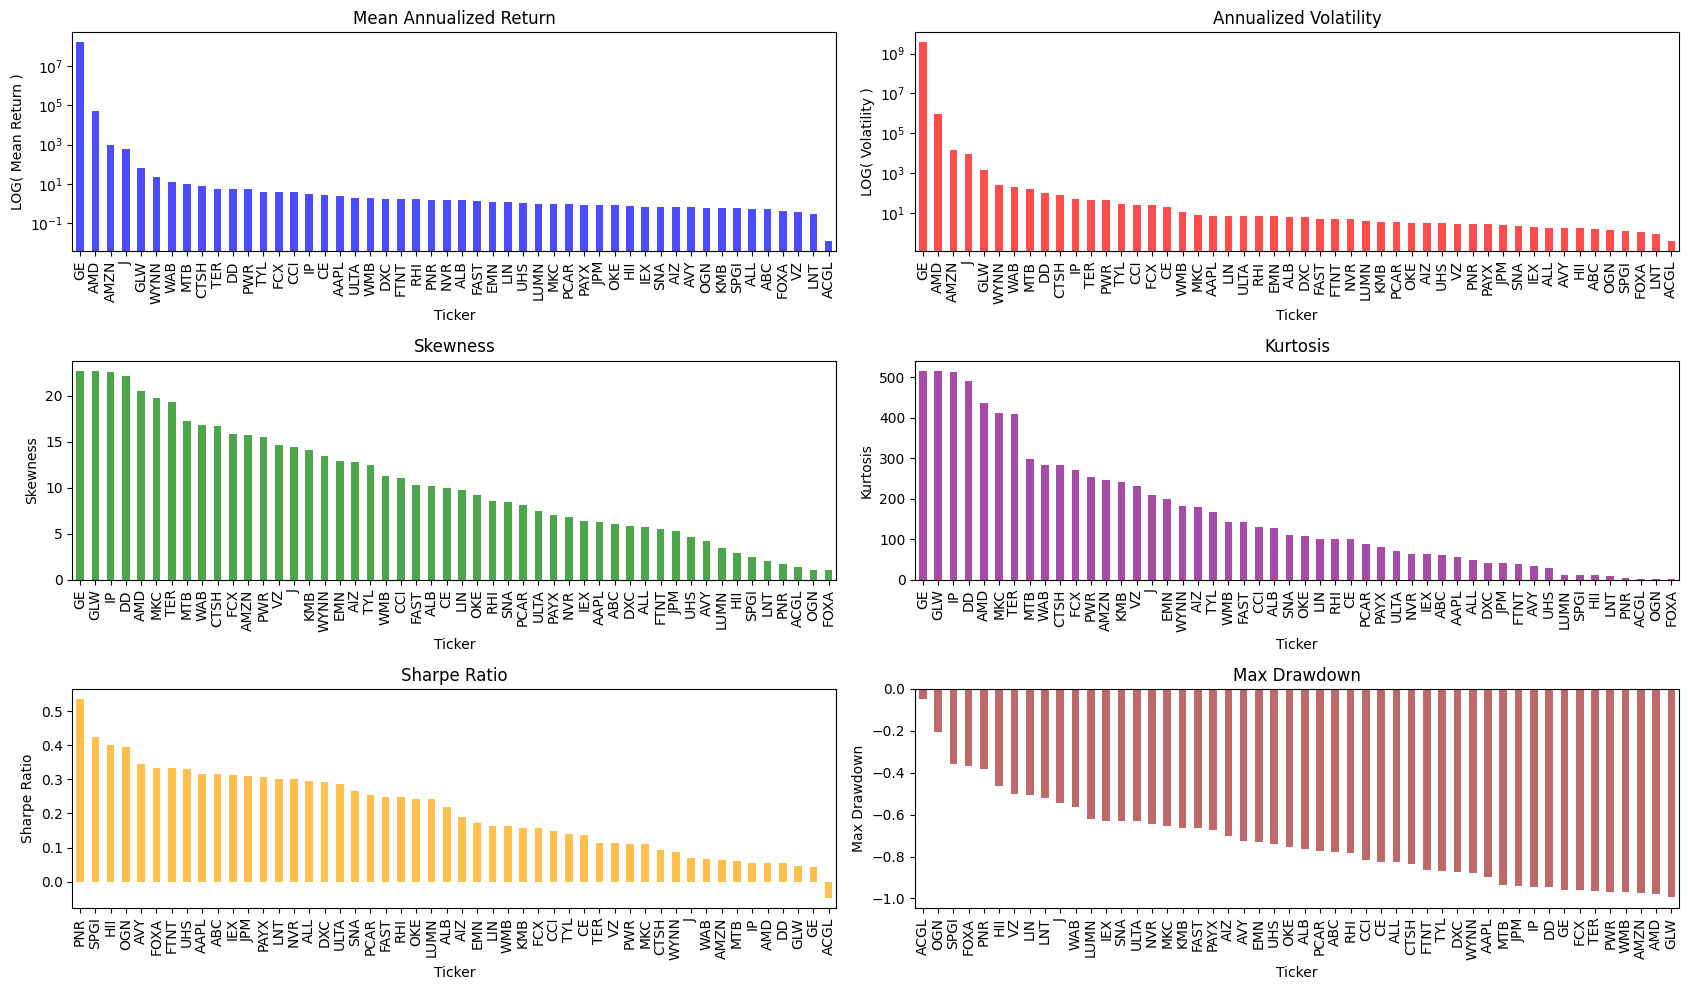

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(17, 10))

def plot_stat_subplot(ax, data, title, ylabel, color, logy=False):
    data.plot(kind='bar', ax=ax, color=color, alpha=0.7, logy=logy)
    ax.set_xlabel('Ticker')
    if logy == False:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel('LOG( ' + ylabel + ' )')
    ax.set_title(title)

# Sort data by each statistic
stats_sorted = {
    stat: stats_stocks[stat].sort_values(ascending=False)
    for stat in ['mean_return', 'volatility', 'skewness', 'kurtosis', 'sharpe_ratio', 'max_drawdown']
}

# Mean Return
plot_stat_subplot(axes[0, 0], stats_sorted['mean_return'], 'Mean Annualized Return', 'Mean Return', 'blue', logy=True)
# Volatility
plot_stat_subplot(axes[0, 1], stats_sorted['volatility'], 'Annualized Volatility', 'Volatility', 'red', logy=True)
# Skewness
plot_stat_subplot(axes[1, 0], stats_sorted['skewness'], 'Skewness', 'Skewness', 'green')
# Kurtosis
plot_stat_subplot(axes[1, 1], stats_sorted['kurtosis'], 'Kurtosis', 'Kurtosis', 'purple')
# Sharpe Ratio
plot_stat_subplot(axes[2, 0], stats_sorted['sharpe_ratio'], 'Sharpe Ratio', 'Sharpe Ratio', 'orange')
# Max Drawdown
plot_stat_subplot(axes[2, 1], stats_sorted['max_drawdown'], 'Max Drawdown', 'Max Drawdown', 'brown')

plt.tight_layout()
plt.show()


***

<h2 style='color:Blue'> 2. Momentum indicator portfolios </h2>

Momentrum indicators are technical analysis tools used to determine the strength or weakness of a stock's price. Momentum measures the rate of the rise or fall of stock prices.

1. For each stock and each date, build a Momentum indicator which is defined as the cumulated return over the past six months.

In [23]:
# Calculate the 6-month momentum for each stock
df_tic['momentum_6m'] = df_tic.groupby('tic')['price_close'].pct_change(periods=6)
# Drop rows with missing data for 6 month momentum to avoid errors in the computation of summary sataistics
df_tic.dropna(subset='momentum_6m', inplace=True)

display(df_tic)

,tic,book_to_market,price_close,price_high,price_low,monthly_returns,annual_returns,cum_returns,cum_max,drawdown,momentum_6m
date,,,,,,,,,,,
1988-05-01,FAST,0.215,21.625,22.250,20.0000,0.054878,0.898572,1.696078e+00,1.696078e+00,0.000000,0.696078
1988-06-01,FAST,0.215,22.000,22.000,20.0000,0.017341,0.229133,1.725490e+00,1.725490e+00,0.000000,0.491525
1988-07-01,FAST,0.215,25.000,27.000,21.5000,0.136364,3.636689,1.960784e+00,1.960784e+00,0.000000,0.538462
1988-08-01,FAST,0.164,23.750,25.500,22.5000,-0.050000,-0.459640,1.862745e+00,1.960784e+00,-0.050000,0.417910
1988-09-01,FAST,0.164,19.750,20.250,15.3330,-0.168421,-0.890644,1.549020e+00,1.960784e+00,-0.210000,0.264000
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,FTNT,0.014,48.690,63.160,48.3100,-0.183738,-0.912511,2.056478e+24,1.517967e+25,-0.864524,-0.858673
2022-09-01,FTNT,0.014,49.130,55.940,47.3700,0.009037,0.113997,2.075062e+24,1.517967e+25,-0.863300,-0.856236
2022-10-01,FTNT,0.014,57.160,57.335,45.7400,0.163444,5.150996,2.414218e+24,1.517967e+25,-0.840957,-0.802221


2. Use the characteristics Book-to-Market and Momentum to build tercile portfolios, called:
- book-to-market :  Value_high, Value_med, Value_low 
- momentum  :  MoM_high,MoM_med, MoM_low 

    To construct the six portfolios, at each date and for each one of the two characteristic, split your 50 stocks in three equally weighted groups of similar sizes (example: for momentum in Jan 2000 you may have 16 stocks in the low Momentum group, 15 in the Middle group, 15 in the high Momentum group and 4 stocks with missing observations at this date). 

In [24]:
def create_equally_weighted_groups(x, num_groups=3):
    n = len(x)
    step = n // num_groups
    indices = np.argsort(x)
    terciles = np.empty_like(indices)
    terciles[indices[:step]] = 0
    terciles[indices[step:2 * step]] = 1
    terciles[indices[2 * step:]] = 2
    return terciles

# Create tercile portfolios based on Book-to-Market and Momentum
df_tic['bm_tercile'] = df_tic.groupby('date')['book_to_market'].transform(create_equally_weighted_groups)
df_tic['mom_tercile'] = df_tic.groupby('date')['momentum_6m'].transform(create_equally_weighted_groups)

# Assign portfolio names
bm_labels = ['Value_low', 'Value_med', 'Value_high']
mom_labels = ['MoM_low', 'MoM_med', 'MoM_high']

df_tic['bm_tercile'] = df_tic['bm_tercile'].map(dict(enumerate(bm_labels)))
df_tic['mom_tercile'] = df_tic['mom_tercile'].map(dict(enumerate(mom_labels)))

display(df_tic)

,tic,book_to_market,price_close,price_high,price_low,monthly_returns,annual_returns,cum_returns,cum_max,drawdown,momentum_6m,bm_tercile,mom_tercile
date,,,,,,,,,,,,,
1988-05-01,FAST,0.215,21.625,22.250,20.0000,0.054878,0.898572,1.696078e+00,1.696078e+00,0.000000,0.696078,Value_low,MoM_high
1988-06-01,FAST,0.215,22.000,22.000,20.0000,0.017341,0.229133,1.725490e+00,1.725490e+00,0.000000,0.491525,Value_low,MoM_high
1988-07-01,FAST,0.215,25.000,27.000,21.5000,0.136364,3.636689,1.960784e+00,1.960784e+00,0.000000,0.538462,Value_low,MoM_high
1988-08-01,FAST,0.164,23.750,25.500,22.5000,-0.050000,-0.459640,1.862745e+00,1.960784e+00,-0.050000,0.417910,Value_low,MoM_high
1988-09-01,FAST,0.164,19.750,20.250,15.3330,-0.168421,-0.890644,1.549020e+00,1.960784e+00,-0.210000,0.264000,Value_low,MoM_high
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,FTNT,0.014,48.690,63.160,48.3100,-0.183738,-0.912511,2.056478e+24,1.517967e+25,-0.864524,-0.858673,Value_low,MoM_low
2022-09-01,FTNT,0.014,49.130,55.940,47.3700,0.009037,0.113997,2.075062e+24,1.517967e+25,-0.863300,-0.856236,Value_low,MoM_low
2022-10-01,FTNT,0.014,57.160,57.335,45.7400,0.163444,5.150996,2.414218e+24,1.517967e+25,-0.840957,-0.802221,Value_low,MoM_low


3. Present annualized performance statistics for the 6 portfolios.

In [25]:
def compute_summary_statistics(df_tic, portfolio_col, portfolio_names):
    def max_drawdown(returns):
        cum_returns = (1 + returns).cumprod()
        cum_max_return = cum_returns.cummax()
        drawdown = cum_returns / cum_max_return - 1
        return drawdown.min()

    # Compute the summary statistics for each month
    monthly_stats = df_tic.groupby(['date', portfolio_col])['annual_returns'].agg(
        mean_return=lambda x: np.mean(x),
        volatility=lambda x: np.std(x),
        skewness=lambda x: x.skew(),
        kurtosis=lambda x: x.kurt(),
        max_drawdown=lambda x: max_drawdown(x)
    )

    # Annualize mean_return and volatility
    monthly_stats['annualized_mean_return'] = (1 + monthly_stats['mean_return'])**12 - 1
    monthly_stats['annualized_volatility'] = monthly_stats['volatility'] * np.sqrt(12)

    # Compute the annualized Sharpe ratio
    risk_free_rate_annual = (1 + risk_free_rate)**12 - 1
    epsilon = 1e-8
    monthly_stats['sharpe_ratio'] = (monthly_stats['annualized_mean_return'] - risk_free_rate_annual) / (monthly_stats['annualized_volatility'] + epsilon)

    # Average the statistics for each portfolio
    portfolio_stats = monthly_stats.groupby([portfolio_col]).mean()

    # Filter the desired portfolios
    portfolio_stats = portfolio_stats.reset_index()
    filtered_stats = portfolio_stats[
        (portfolio_stats[portfolio_col].isin(portfolio_names))
    ]

    # Assign the specified index labels
    filtered_stats = filtered_stats.set_index(portfolio_col)

    # Select the required columns
    selected_stats = filtered_stats[['annualized_mean_return', 'annualized_volatility', 'sharpe_ratio', 'skewness', 'kurtosis', 'max_drawdown']]

    return selected_stats

# STATS BM PORTFOLIOS
portfolio_col = 'bm_tercile'
portfolio_names = ['Value_high', 'Value_med', 'Value_low']
bm_stats = compute_summary_statistics(df_tic, portfolio_col, portfolio_names)

# STATS BM PORTFOLIOS
portfolio_col = 'mom_tercile'
portfolio_names = ['MoM_high', 'MoM_med', 'MoM_low']
mom_stats = compute_summary_statistics(df_tic, portfolio_col, portfolio_names)

stats_bm_mom = pd.concat([bm_stats, mom_stats], axis=0)
display(stats_bm_mom)


,annualized_mean_return,annualized_volatility,sharpe_ratio,skewness,kurtosis,max_drawdown
Value_high,2.518704e+44,2.854615e+02,2.303501e+39,1.481056,3.014009,-0.692652
Value_low,2.504034e+71,4.461540e+04,1.392971e+64,1.406990,2.751811,-0.696178
Value_med,2.029874e+114,1.433302e+08,2.776907e+103,1.306502,2.473458,-0.687974
MoM_high,2.006271e+114,1.417075e+08,2.744617e+103,1.656043,3.664604,-0.534807
MoM_low,1.827573e+30,1.798243e+01,5.022104e+26,1.320745,2.368183,-0.816867
MoM_med,1.981548e+48,4.274814e+02,9.278689e+42,1.228563,2.047813,-0.634745


<h2 style='color:Blue'> 3. Long-short portfolios </h2>

Build two long-short portfolios for Value and Momentum using the tercile portfolios. Backtest the portfolio and an equal weighed portfolio investing in the 50 stocks. Plot cumulated returns and present annualized performance statistics.

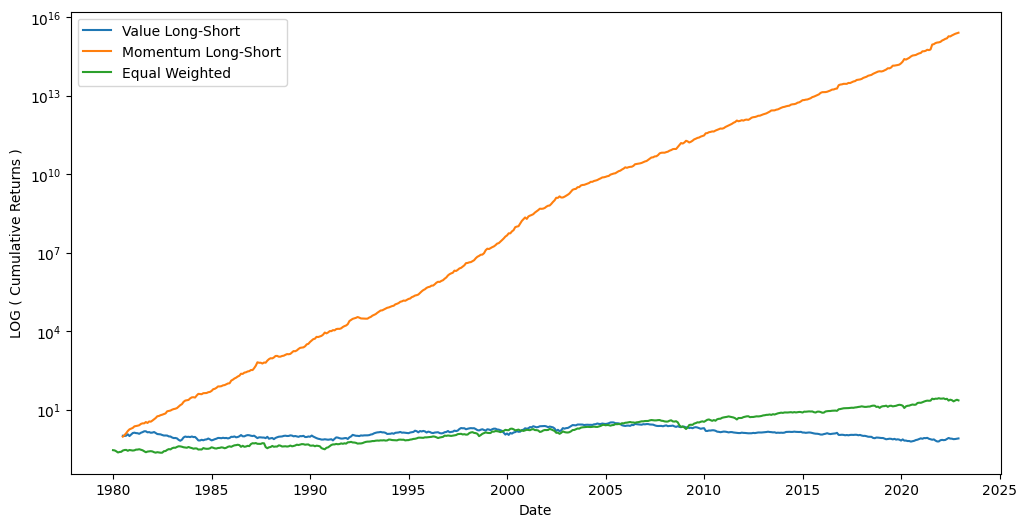

,Annualized Average Return,Annualized Volatility,Annualized Sharpe ratio,Skewness,Kurtosis,Max Drawdown
Value_long_short,0.015120,0.203724,0.074219,0.173295,1.148806,-0.815434
MoM_long_short,0.893770,0.241375,3.702825,1.159193,4.626824,-0.139417
Equal_weighted,0.123306,0.203264,0.606629,-0.243811,2.403131,-0.545124


In [26]:
# Calculate equal-weighted returns for each tercile portfolio
bm_tercile_returns = df_tic.groupby(['date', 'bm_tercile'])['monthly_returns'].mean().unstack()
mom_tercile_returns = df_tic.groupby(['date', 'mom_tercile'])['monthly_returns'].mean().unstack()

# Construct long-short portfolios
bm_tercile_returns['Value_long_short'] = bm_tercile_returns['Value_high'] - bm_tercile_returns['Value_low']
mom_tercile_returns['MoM_long_short'] = mom_tercile_returns['MoM_high'] - mom_tercile_returns['MoM_low']

tercile_returns = pd.concat([bm_tercile_returns['Value_long_short'],mom_tercile_returns['MoM_long_short']], axis=1)

# Backtest an equal-weighted portfolio investing in the 50 stocks
equal_weighted_returns = df_tic.groupby('date')['monthly_returns'].mean()
equal_weighted_cumulative = (1 + equal_weighted_returns).cumprod()

# Calculate the cumulative returns for each long-short portfolio
tercile_returns['Value_long_short'] = (1 + tercile_returns['Value_long_short']).cumprod()
tercile_returns['MoM_long_short'] = (1 + tercile_returns['MoM_long_short']).cumprod()

# Calculate annualized performance statistics
annualized_mean_return = df_tic.groupby(['bm_tercile', 'mom_tercile'])['monthly_returns'].mean() * 12
annualized_volatility = df_tic.groupby(['bm_tercile', 'mom_tercile'])['monthly_returns'].std() * np.sqrt(12)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(tercile_returns.index, tercile_returns['Value_long_short'], label='Value Long-Short')
plt.plot(tercile_returns.index, tercile_returns['MoM_long_short'], label='Momentum Long-Short')
plt.plot(equal_weighted_returns.index, equal_weighted_cumulative, label='Equal Weighted')
plt.xlabel('Date')
plt.ylabel('LOG ( Cumulative Returns )')
plt.yscale('log')
plt.legend()
plt.show()

# Annualized performance statistics
portfolios = {
    'Value_long_short': tercile_returns['Value_long_short'],
    'MoM_long_short': tercile_returns['MoM_long_short'],
    'Equal_weighted': equal_weighted_cumulative
}

stats_LS = pd.DataFrame(index=['Annualized Average Return', 'Annualized Volatility', 'Annualized Sharpe ratio', 'Skewness', 'Kurtosis', 'Max Drawdown'], columns=portfolios.keys())

for name, portfolio in portfolios.items():
    returns = portfolio.pct_change().dropna()
    avg_return = returns.mean() * 12
    volatility = returns.std() * np.sqrt(12)
    sharpe_ratio = avg_return / volatility
    skewness_ = skew(returns)
    kurtosis_ = kurtosis(returns)
    drawdowns = (portfolio / portfolio.cummax()) - 1
    max_drawdown = drawdowns.min()
    stats_LS[name] = [avg_return, volatility, sharpe_ratio, skewness_, kurtosis_, max_drawdown]

stats_LS = stats_LS.T
display(stats_LS)



<h2 style='color:Blue'> 4. composite characteristics of momentum and value </h2>

Naturally, neither Value nor Momentum is the perfect predictor of returns. To combine the information that each characteristic contains, construct a composite characteristics. To this end, standardize in each month each characteristic to have a cross-sectional mean (standard deviation) of zero (one) and combine them into a single characteristicSitdefined as:

-- equation formula -- 

where the Mean and Standard deviation are taken over all stocks in the cross-section of month t. Now, sort the stocks on the composite characteristic and construct the long-short portfolio using tercile portfolios on this charateristics. Backtest this long-short portfolio. Plot cumulated returns and present annualized performance statistics for this long-short portfolio.

In [27]:
df_tic = df_tic.reset_index()

# Calculate the mean and standard deviation of BMit and Momit for each month
mean_bm = df_tic.groupby(df_tic['date'])['book_to_market'].mean()
std_bm = df_tic.groupby(df_tic['date'])['book_to_market'].std()
mean_mom = df_tic.groupby(df_tic['date'])['momentum_6m'].mean()
std_mom = df_tic.groupby(df_tic['date'])['momentum_6m'].std()

#Merge tables
df_tic = df_tic.merge(mean_bm, how='left', on='date').rename(columns={'book_to_market_y': 'mean_bm'})
df_tic = df_tic.merge(std_bm, how='left', on='date').rename(columns={'book_to_market': 'std_bm'})
df_tic = df_tic.merge(mean_mom, how='left', on='date').rename(columns={'momentum_6m_y': 'mean_mom'})
df_tic = df_tic.merge(std_mom, how='left', on='date').rename(columns={'momentum_6m': 'std_mom'})

# Standardize BMit and Momit
df_tic['std_bm_normalized'] = (df_tic['book_to_market_x'] - df_tic['mean_bm']) / df_tic['std_bm']
df_tic['std_mom_normalized'] = (df_tic['momentum_6m_x'] - df_tic['mean_mom']) / df_tic['std_mom']

#Calculate composite characteristic
df_tic['sit'] = df_tic['std_bm_normalized'] + df_tic['std_mom_normalized']

In [28]:
df_tic

,date,tic,book_to_market_x,price_close,price_high,price_low,monthly_returns,annual_returns,cum_returns,cum_max,...,momentum_6m_x,bm_tercile,mom_tercile,mean_bm,std_bm,mean_mom,std_mom,std_bm_normalized,std_mom_normalized,sit
0,1988-05-01,FAST,0.215,21.625,22.250,20.0000,0.054878,0.898572,1.696078e+00,1.696078e+00,...,0.696078,Value_low,MoM_high,0.676000,0.483867,0.159456,0.290479,-0.952740,1.847370,0.894630
1,1988-06-01,FAST,0.215,22.000,22.000,20.0000,0.017341,0.229133,1.725490e+00,1.725490e+00,...,0.491525,Value_low,MoM_high,0.676000,0.483867,0.186501,0.227123,-0.952740,1.342989,0.390249
2,1988-07-01,FAST,0.215,25.000,27.000,21.5000,0.136364,3.636689,1.960784e+00,1.960784e+00,...,0.538462,Value_low,MoM_high,0.745765,0.688347,0.139946,0.219139,-0.771071,1.818549,1.047478
3,1988-08-01,FAST,0.164,23.750,25.500,22.5000,-0.050000,-0.459640,1.862745e+00,1.960784e+00,...,0.417910,Value_low,MoM_high,0.665333,0.663606,-0.021855,0.202242,-0.755469,2.174452,1.418984
4,1988-09-01,FAST,0.164,19.750,20.250,15.3330,-0.168421,-0.890644,1.549020e+00,1.960784e+00,...,0.264000,Value_low,MoM_high,0.665333,0.663606,0.062891,0.280061,-0.755469,0.718090,-0.037379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15572,2022-08-01,FTNT,0.014,48.690,63.160,48.3100,-0.183738,-0.912511,2.056478e+24,1.517967e+25,...,-0.858673,Value_low,MoM_low,0.410182,0.291100,-0.121544,0.237399,-1.360980,-3.105021,-4.466000
15573,2022-09-01,FTNT,0.014,49.130,55.940,47.3700,0.009037,0.113997,2.075062e+24,1.517967e+25,...,-0.856236,Value_low,MoM_low,0.410273,0.290998,-0.228417,0.210345,-1.361772,-2.984715,-4.346487
15574,2022-10-01,FTNT,0.014,57.160,57.335,45.7400,0.163444,5.150996,2.414218e+24,1.517967e+25,...,-0.802221,Value_low,MoM_low,0.410818,0.290636,-0.110347,0.234689,-1.365344,-2.948051,-4.313395
15575,2022-11-01,FTNT,0.014,53.160,58.290,42.6101,-0.069979,-0.581290,2.245274e+24,1.517967e+25,...,-0.819270,Value_low,MoM_low,0.474186,0.393908,-0.081137,0.238370,-1.168258,-3.096590,-4.264848


<h2 style='color:Blue'> 5. 50% Value LS & 50% Momentum LS </h2>

Discuss how the performance of the strategy at the previous point compares to a mixed strategy that simply invests 50% in the the value long-short portfolio and %50 in the momentum long- short portfolio.

/var/folders/zm/fbbwn3vj6ll7mfyvrh9l8dr80000gn/T/ipykernel_81264/3432648303.py:8: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mixed_stats = pd.Series()


,average_return,volatility,Sharpe_ratio,skewness,kurtosis,max_drawdown
Mixed_long_short,0.454445,0.153626,2.958134,1.058975,2.708536,-0.096715


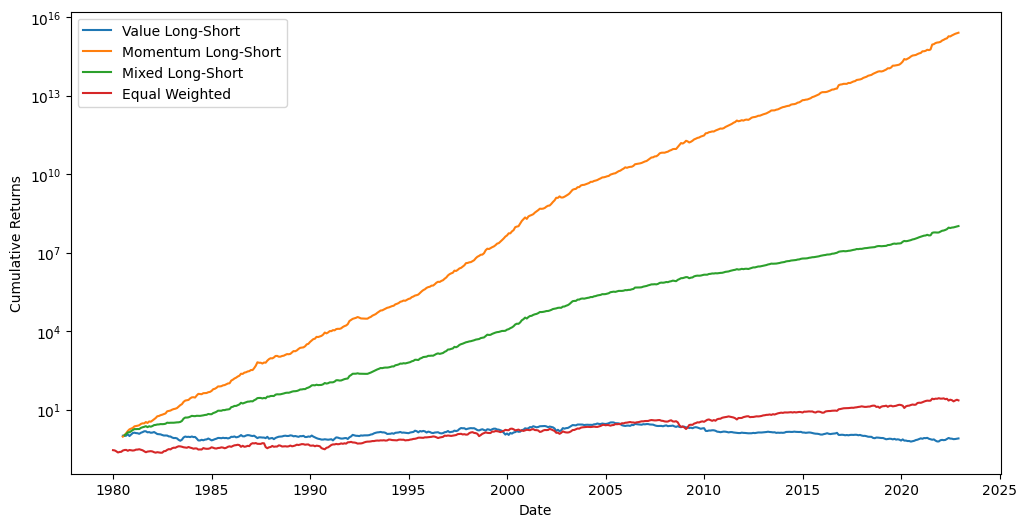

In [29]:
# Create the mixed long-short portfolio
tercile_returns['Mixed_long_short'] = 0.5 * tercile_returns['Value_long_short'].pct_change() + 0.5 * tercile_returns['MoM_long_short'].pct_change()

# Calculate cumulative returns
mixed_cumulative_returns = (1 + tercile_returns['Mixed_long_short']).cumprod()

# Calculate annualized performance statistics
mixed_stats = pd.Series()
mixed_stats['average_return'] = tercile_returns['Mixed_long_short'].mean() * 12
mixed_stats['volatility'] = tercile_returns['Mixed_long_short'].std() * np.sqrt(12)
mixed_stats['Sharpe_ratio'] = mixed_stats['average_return'] / mixed_stats['volatility']
mixed_stats['skewness'] = tercile_returns['Mixed_long_short'].skew()
mixed_stats['kurtosis'] = tercile_returns['Mixed_long_short'].kurt()
mixed_stats['max_drawdown'] = (mixed_cumulative_returns / mixed_cumulative_returns.cummax() - 1).min()

mixed_stats = pd.DataFrame(mixed_stats).transpose()
mixed_stats.index = ['Mixed_long_short']
display(mixed_stats)

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(tercile_returns.index, tercile_returns['Value_long_short'], label='Value Long-Short')
plt.plot(tercile_returns.index, tercile_returns['MoM_long_short'], label='Momentum Long-Short')
plt.plot(tercile_returns.index, mixed_cumulative_returns, label='Mixed Long-Short')
plt.plot(equal_weighted_returns.index, equal_weighted_cumulative, label='Equal Weighted')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.yscale('log')
plt.legend()
plt.show()
